### Import and Organize Data 

In [3]:
library(tidyverse)

#Read in data
path_choose <- file.choose()
raw_data <- read_csv(path_choose, skip = 4, col_names = FALSE)
raw_headers <- raw_data %>% slice(1:4)

raw_data2 <- raw_data %>% slice(-(1:4))
rm(raw_data)

##Eliminate rows labelled with asterisk (indicating errant data)

#bad_data <- raw_data2 %>% filter(str_detect(.$X2, "\\*"))
#raw_data2 %>% filter(str_detect(.$X1, "\\*"))
clean_data1 <- raw_data2 %>% filter(!str_detect(.$X1, "\\*"))

#Replace "NA" in "FREQ" and "WORK" to "1" == "Never"/"NONE"
clean_data2 <- bind_rows(raw_headers, clean_data1)
rm(raw_headers)
rm(clean_data1)
clean_data3 <- clean_data2

for (i in 3:length(clean_data2)){ #Iterate through "Freq" columns
  if (str_detect(clean_data2[3,i], "FREQ") || str_detect(clean_data2[3,i], "WORK")){
    for (j in 5:length(clean_data2[[1]])){ #Iterate through "Freq" data rows
      if (is.na(clean_data2[j,i])){ 
        clean_data3[j,i] <- "1"}
    }
  }
}
#could also reorganize data and use replace_na()

clean_data4 <- clean_data3[5:length(clean_data3[[1]]),] # Extract just data
colnames(clean_data4) <- unlist(slice(clean_data3, 4)) #Rename columns
rm(i,j)
rm(clean_data2)
rm(clean_data3)

Rows: 789 Columns: 62
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (62): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# sessionInfo()

### Pivot Data

In [4]:
pivot_data1 <- clean_data4

# Isolate "Frequency" data
pivot_freq1 <- pivot_data1 %>% select(contains("SITE"))
pivot_freq1 <- bind_cols(pivot_freq1, select(pivot_data1, contains("ID")))
pivot_freq1 <- bind_cols(pivot_freq1, select(pivot_data1, contains("FREQ")))

pivot_freq2 <- pivot_longer(pivot_freq1, cols = NECK_FREQ:L_FOOT_FREQ, names_to = "BODY_PART", values_to="FREQ")
pivot_freq2$BODY_PART <- str_replace_all(pivot_freq2$BODY_PART, "_FREQ", "")
rm(pivot_freq1)

# Isolate "Severity" data
pivot_sev1 <- pivot_data1 %>% select(contains("SITE"))
pivot_sev1 <- bind_cols(pivot_sev1, select(pivot_data1, contains("ID")))
pivot_sev1 <- bind_cols(pivot_sev1, select(pivot_data1, contains("SEV")))

pivot_sev2 <- pivot_longer(pivot_sev1, cols = NECK_SEV:L_FOOT_SEV, names_to = "BODY_PART", values_to="SEVERITY")
pivot_sev2$BODY_PART <- str_replace_all(pivot_sev2$BODY_PART, "_SEV", "")
rm(pivot_sev1)

# Isolate "Work Interference" data
pivot_work1 <- pivot_data1 %>% select(contains("SITE"))
pivot_work1 <- bind_cols(pivot_work1, select(pivot_data1, contains("ID")))
pivot_work1 <- bind_cols(pivot_work1, select(pivot_data1, contains("WORK")))

pivot_work2 <- pivot_longer(pivot_work1, cols = NECK_WORK:L_FOOT_WORK, names_to = "BODY_PART", values_to="WORK_INT")
pivot_work2$BODY_PART <- str_replace_all(pivot_work2$BODY_PART, "_WORK", "")
rm(pivot_work1)

# Combine to single data tibble

all_survey1 <- bind_cols(pivot_freq2, select(pivot_sev2, SEVERITY), select(pivot_work2, WORK_INT))
all_survey1 <- rename(all_survey1, SITE_QUARRY = `SITE / QUARRY` )



### Fix Errors

In [5]:
# all_survey1 %>% filter(FREQ == 11) # To view: Typo "11" should be '1'    

for (i in 1:length(all_survey1$FREQ)){
  if (all_survey1$FREQ[i] == "11"){all_survey1$FREQ[i] <- '1'}
}

#Rename the Site/Quarry where name is missing
# all_survey1 %>% filter(is.na(all_survey1$SITE_QUARRY))    # To view

for (i in 1:length(all_survey1$SITE_QUARRY)){
  if (is.na(all_survey1$SITE_QUARRY[i])){all_survey1$SITE_QUARRY[i] <- "Unknown (South Texas?)"}
} 

#fix site/quarry names to eliminate spurious numbers/dates

# all_survey1 %>% filter(contains(.$SITE_QUARRY, str_detect("")))    # To view

for (i in 1:length(all_survey1$SITE_QUARRY)){
  if (str_detect(all_survey1$SITE_QUARRY[i], "Round 2-Hunter")){
    all_survey1$SITE_QUARRY[i] <- "Round 2-Hunter Cement Plant"
  }
  if (str_detect(all_survey1$SITE_QUARRY[i], "Midlothian Cement")){
    all_survey1$SITE_QUARRY[i] <- "Midlothian Cement Plant"
  }
}

all_survey2 <- tibble(all_survey1)

### Factorize

In [6]:
all_survey2$SITE_QUARRY <- as.factor(all_survey2$SITE_QUARRY)
all_survey2$BODY_PART <- as.factor(all_survey2$BODY_PART)
all_survey2$ID <- as.integer(all_survey2$ID)
all_survey2$FREQ <- factor(as_factor(all_survey2$FREQ), levels = c('1','2','3','4','5'))
all_survey2$SEVERITY <- as_factor(all_survey2$SEVERITY)
all_survey2$WORK_INT <- as_factor(all_survey2$WORK_INT)

### Plots setup

In [7]:
library(RColorBrewer)
# library(extrafont, extrafontdb)
# font_import()
# loadfonts(device="win")
image_path <- choose.dir()
setwd(image_path)

### Plot 1 - Overall Frequency

**Employee reports of how often they experience bodily pain on the job.**

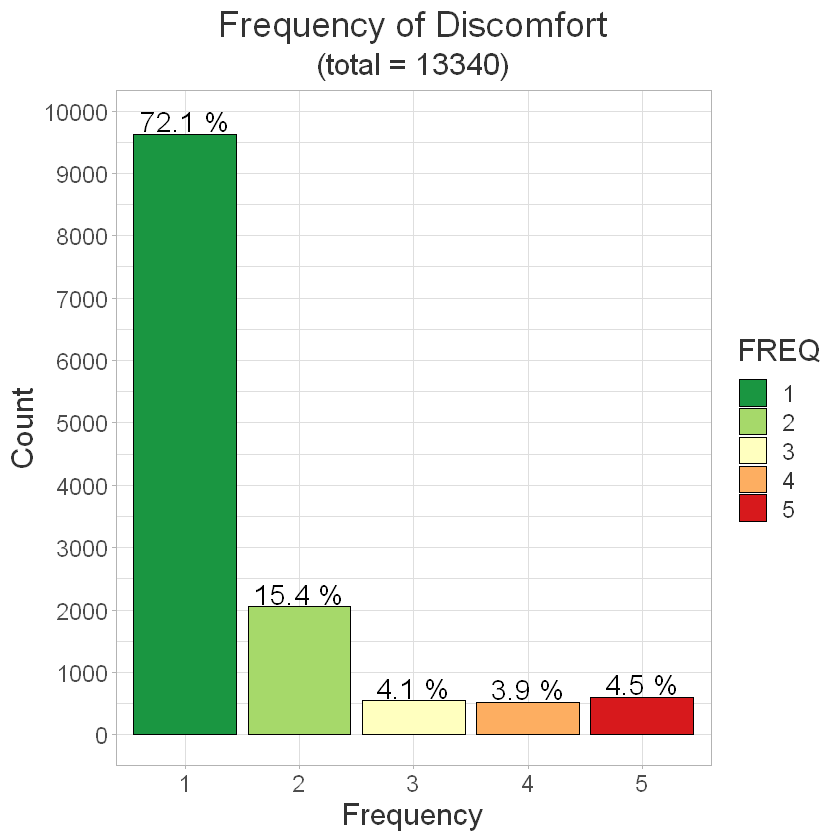

In [8]:
count1 <- count(all_survey2, FREQ)
#count1$FREQ <- factor(c("5+ Times / day", "Once a day", "3-4 times / week", "1-2 times / week", "Never"))

total_count <- sum(count1["n"])

g1 <- ggplot(data = count1, mapping = aes(x=FREQ, y = n)) + theme_light() +
# # this is commented out until "extrafont" package can be installed in conda
#   theme(text=element_text(family = "Segoe UI", color="grey20", size =18),
#         plot.title = element_text(hjust = 0.5), 
#         plot.subtitle = element_text(hjust = 0.5)) +
  theme(text=element_text(color="grey20", size =18),
        plot.title = element_text(hjust = 0.5), 
        plot.subtitle = element_text(hjust = 0.5)) +
  labs(title = "Frequency of Discomfort", x = "Frequency", y = "Count", subtitle = "(total = 13340)" ) +
  geom_col( mapping = aes(fill = FREQ), color="black") + 
  scale_fill_brewer(palette="RdYlGn", direction = -1) + 
  scale_y_continuous(breaks = scales::breaks_extended(n=10)) +
  geom_text(aes(label = paste(sprintf("%2.1f", 100*n/total_count),"%") , y = n+210, x = FREQ), size = 6)
  
g1
# png(filename = "Freq Overall.png", width=1280, height=720, pointsize = 18, type = "windows")
# plot(g1)
# dev.off()

| Number | Meaning |
| :---: | :---: |
| **1** | Never |
| **2** | 1-2 times / week |
| **3** | 3-4 times / week |
| **4** | Daily |
| **5** | 5+ Times / day |

### Plot 2 - Frequency of Pain per Body Area/Part

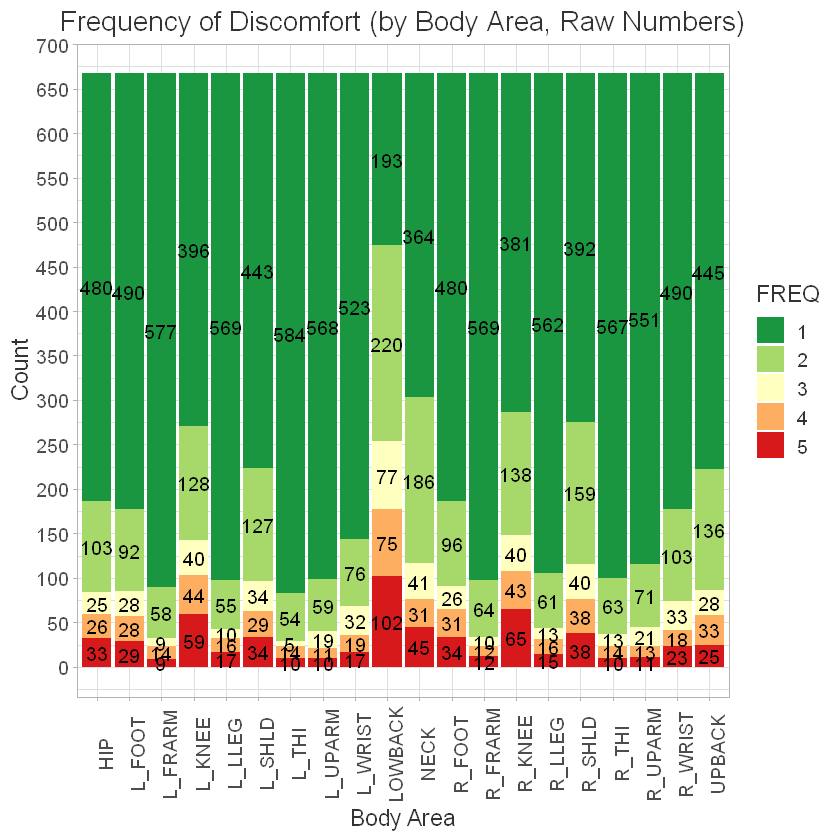

In [9]:
# 2 Freq vs. Body Area--------------------------------

count2 <- count(all_survey2, BODY_PART, FREQ)
count2$n <- as.numeric(count2$n)

g2 <- ggplot(data = count2, mapping = aes(x = BODY_PART, y = n, fill = FREQ)) + 
  theme_light() +
# # this is commented out until "extrafont" package can be installed in conda
#   theme(text=element_text(family = "Segoe UI", color="grey20", size=24),
#         plot.title = element_text(hjust = 0.5), 
#         plot.subtitle = element_text(hjust = 0.5)) +
  theme(text=element_text(color="grey20", size=14),
        plot.title = element_text(hjust = 0.5), 
        plot.subtitle = element_text(hjust = 0.5)) +
  labs(title = "Frequency of Discomfort (by Body Area, Raw Numbers)", x = "Body Area", y = "Count") +
  geom_col() +
  scale_fill_brewer(palette="RdYlGn", direction = -1) +
  scale_y_continuous(breaks = scales::breaks_extended(n=20)) +
  geom_text(mapping = aes(label = as.character(n)), position = position_stack(vjust=0.5, reverse=FALSE), size=4) + 
  theme(axis.text.x = element_text(angle = 90))

g2
# png(filename = "Freq vs Body Area.png", width=1920, height=1080, pointsize = 18, type = "windows")
# plot(g2)
# dev.off()

| Number | Meaning |
| :---: | :---: |
| **1** | Never |
| **2** | 1-2 times / week |
| **3** | 3-4 times / week |
| **4** | Daily |
| **5** | 5+ Times / day |

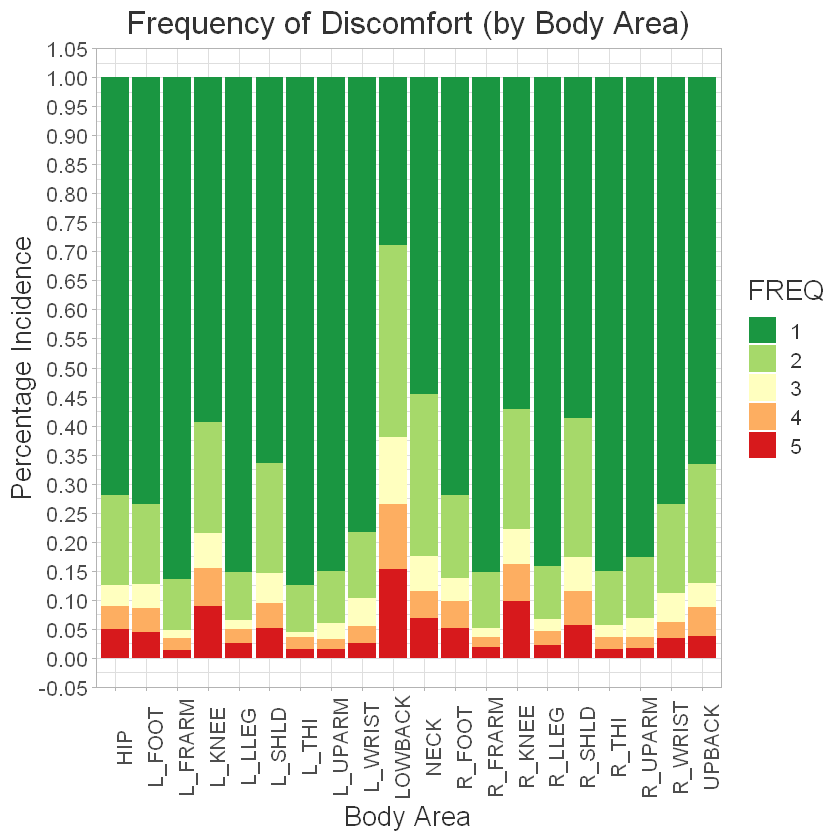

In [10]:
g2a <- ggplot(data = count2, mapping = aes(x = BODY_PART, y = n, fill = FREQ)) + 
  theme_light() +
# # this is commented out until "extrafont" package can be installed in conda
#   theme(text=element_text(family = "Segoe UI", color="grey20", size=24),
#         plot.title = element_text(hjust = 0.5), 
#         plot.subtitle = element_text(hjust = 0.5)) +
  theme(text=element_text(color="grey20", size=16),
        plot.title = element_text(hjust = 0.5), 
        plot.subtitle = element_text(hjust = 0.5)) +
  labs(title = "Frequency of Discomfort (by Body Area)", x = "Body Area", y = "Percentage Incidence") +
  geom_bar(position = "fill", stat = "identity") +
  scale_fill_brewer(palette="RdYlGn", direction = -1) +
  scale_y_continuous(breaks = scales::breaks_extended(n=20)) + 
  theme(axis.text.x = element_text(angle = 90)) #+
  #geom_text(mapping = aes(label = as.character(n)))

g2a
# png(filename = "Freq vs Body Area Perc.png", width=1920, height=1080, pointsize = 18, type = "windows")
# plot(g2a)
# dev.off()

### Plot 3 - Work Interruption due to Pain

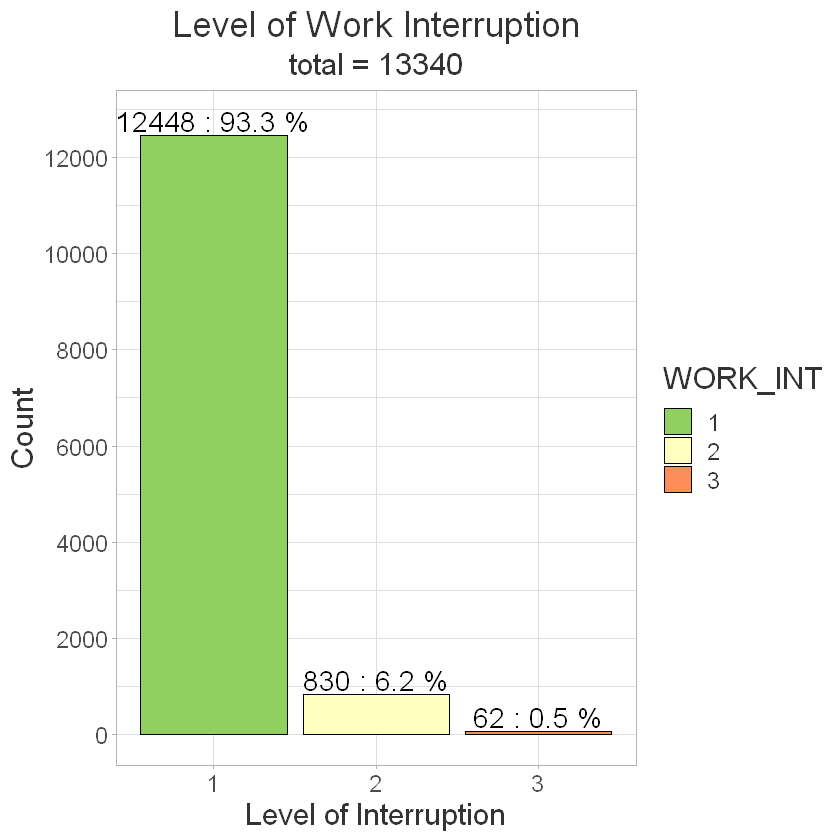

In [11]:
count3 <- count(all_survey2, WORK_INT)
#count3$SEV <- factor(c("5+ Times / day", "Once a day", "3-4 times / week", "1-2 times / week", "Never"))

total_count <- sum(count3["n"])

g3 <- ggplot(data = count3, mapping = aes(x=WORK_INT, y = n)) + theme_light() +
#   theme(text=element_text(family = "Segoe UI", color="grey20", size=18),
#         plot.title = element_text(hjust = 0.5), 
#         plot.subtitle = element_text(hjust = 0.5)) +
  theme(text=element_text(color="grey20", size=18),
        plot.title = element_text(hjust = 0.5), 
        plot.subtitle = element_text(hjust = 0.5)) +
  labs(title = "Level of Work Interruption", x = "Level of Interruption", y = "Count", subtitle = "total = 13340" ) +
  scale_fill_brewer(palette="RdYlGn", direction = -1) +
  geom_col(mapping = aes(fill = WORK_INT), color="black") + 
  scale_y_continuous(breaks = scales::breaks_extended(n=10)) +
  geom_text(aes(label = paste(as.character(n), ":", sprintf("%2.1f", 100*n/total_count), "%"), y = n+300, x = WORK_INT), size=6) #, position = position_dodge(1.1))

g3
# png(filename = "Work Int Overall.png", width=1280, height=720, pointsize = 18, type = "windows")
# plot(g3)
# dev.off()

| Number | Meaning |
| :---: | :---: |
| **1** | Did not interfere with work |
| **2** | Somewhat interfered with work |
| **3** | Substantially interfered with work |

### Plot 5 - Work Interruption vs. Body Area

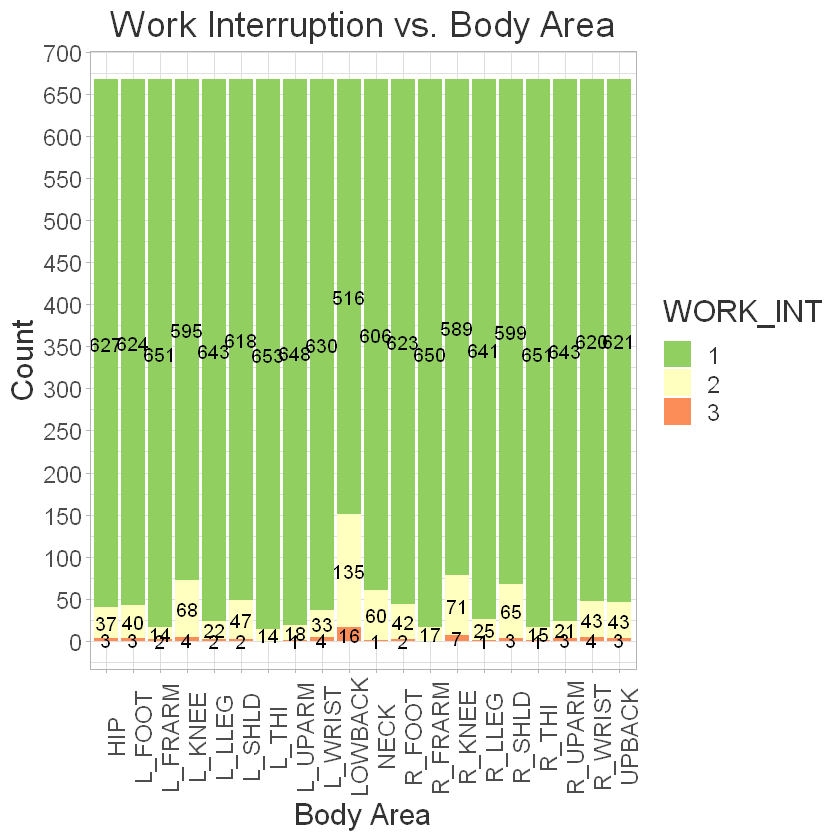

In [12]:
count4 <- count(all_survey2, WORK_INT, BODY_PART)

g4 <- ggplot(data = count4, mapping = aes(x = BODY_PART, y = n, fill=WORK_INT)) + theme_light() +
#   theme(text=element_text(family = "Segoe UI", color="grey20", size=24),
#         plot.title = element_text(hjust = 0.5), 
#         plot.subtitle = element_text(hjust = 0.5)) +
  theme(text=element_text(color="grey20", size=18),
        plot.title = element_text(hjust = 0.5), 
        plot.subtitle = element_text(hjust = 0.5)) +
  labs(title = "Work Interruption vs. Body Area", x = "Body Area", y = "Count") +
  geom_col() +
  scale_fill_brewer(palette="RdYlGn", direction = -1) +
  scale_y_continuous(breaks = scales::breaks_extended(n=20)) +
  geom_text(aes(label = as.character(n)), position = position_stack(vjust=0.5), size=4) + 
  theme(axis.text.x = element_text(angle = 90))

g4
# png(filename = "Work Int vs. Body Area.png", width=1920, height=1080, pointsize = 18, type = "windows")
# plot(g4)
# dev.off()

### Plot 6 - Work Interruption vs. Work Site

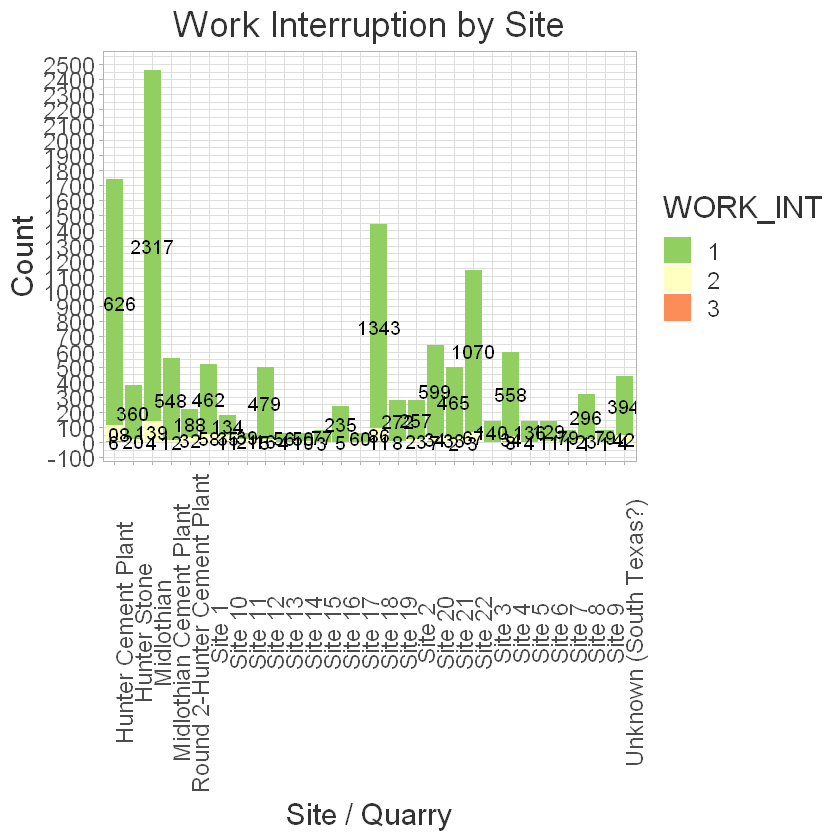

In [13]:
# all_survey2 %>% filter(is.na(SITE_QUARRY)) 

count6 <- count(all_survey2, WORK_INT, SITE_QUARRY)

g6 <- ggplot(data = count6, mapping = aes(x = SITE_QUARRY, y=n, fill = WORK_INT)) +
  theme_light() + 
#   theme(text=element_text(family = "Segoe UI", color="grey20", size=24),
#         plot.title = element_text(hjust = 0.5), 
#         plot.subtitle = element_text(hjust = 0.5)) +
  theme(text=element_text(color="grey20", size=18),
        plot.title = element_text(hjust = 0.5), 
        plot.subtitle = element_text(hjust = 0.5)) +
  labs(title = "Work Interruption by Site", x = "Site / Quarry", y = "Count") +
  geom_col() + 
  scale_fill_brewer(palette="RdYlGn", direction = -1) +
  scale_y_continuous(breaks = scales::breaks_extended(n=20)) +
  geom_text(aes(label = as.character(n)), position = position_stack(vjust=0.5), size=4) +
  theme(axis.text.x = element_text(angle = 90))

g6
# png(filename = "Work Interruption by Site.png", width=1920, height=1080, pointsize = 18, type = "windows")
# plot(g6)
# dev.off()

### Plot 7 - Pain Before and After: Cement Plant

**Incidences of pain reported before and after treatment intervention** 

Joining, by = c("TREAT", "FREQ", "WORK_INT", "n")
Joining, by = c("TREAT", "FREQ", "n")


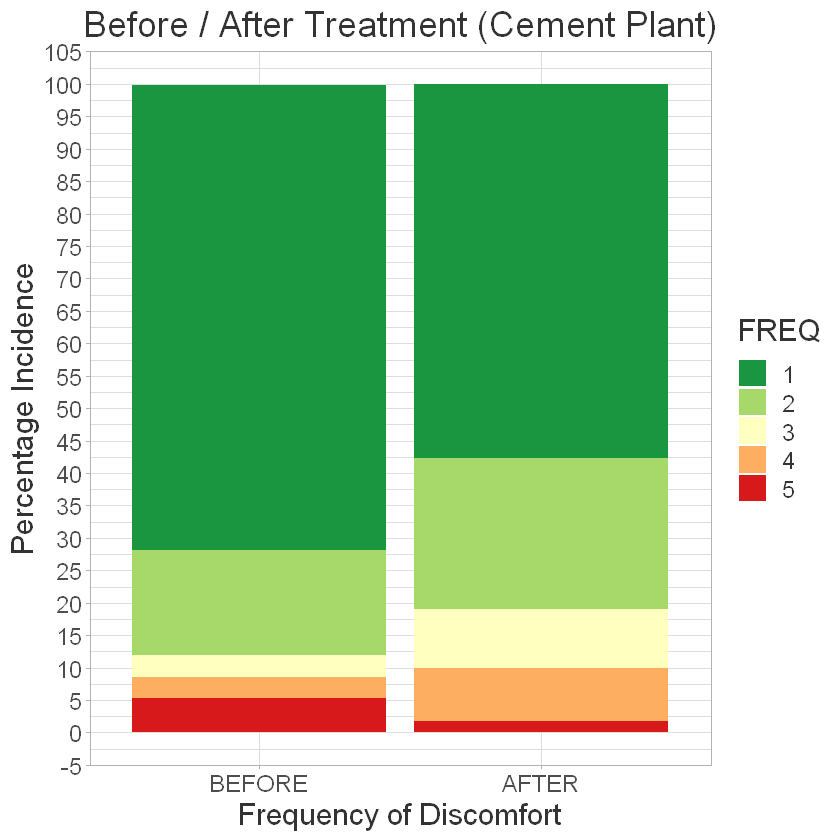

In [16]:
before <- all_survey2 %>% filter(SITE_QUARRY == "Hunter Cement Plant")
before <- add_column(before, TREAT = "BEFORE", .before=TRUE )
before_count <- count(before, TREAT, FREQ, WORK_INT)
before_count_perc <- before_count
before_count_perc$n <- round( before_count$n/sum(before_count$n)*100, 1)

after <- all_survey2 %>% filter(SITE_QUARRY =="Round 2-Hunter Cement Plant")
after <- add_column(after, TREAT = "AFTER", .before=TRUE )
after_count <- count(after, TREAT, FREQ, WORK_INT)
after_count_perc <- after_count
after_count_perc$n <- round( after_count_perc$n/sum(after_count_perc$n)*100, 1)

count7 <- full_join(before_count_perc, after_count_perc)
count7$TREAT <- fct_rev(as.factor(count7$TREAT))
count7a <- full_join(count(before, TREAT, FREQ), count(after, TREAT, FREQ))
count7a$TREAT <- fct_rev(as.factor(count7a$TREAT))

g7 <- ggplot(data = count7, mapping = aes(x = TREAT, y = n, fill=FREQ)) +
  theme_light() + 
#   theme(text=element_text(family = "Segoe UI", color="grey20", size=24),
#         plot.title = element_text(hjust = 0.5), 
#         plot.subtitle = element_text(hjust = 0.5)) +
  theme(text=element_text(color="grey20", size=18),
        plot.title = element_text(hjust = 0.5), 
        plot.subtitle = element_text(hjust = 0.5)) +
  labs(title = "Before / After Treatment (Cement Plant)", x = "Frequency of Discomfort", y = "Percentage Incidence") +
  geom_col() +
  scale_fill_brewer(palette="RdYlGn", direction = -1) +
  scale_y_continuous(breaks = scales::breaks_extended(n=20))
  #geom_text(aes(label = as.character(count7a['n'])), position = position_stack(vjust=0.5))

g7
# png(filename = "Before-After Freq.png", width=1920/2, height=1080, pointsize = 18, type = "windows")
# plot(g7)
# dev.off()

| Number | Meaning |
| :---: | :---: |
| **1** | Never |
| **2** | 1-2 times / week |
| **3** | 3-4 times / week |
| **4** | Daily |
| **5** | 5+ Times / day |

### Plot 7 - Work Interruption Before and After: Hunter Cement Plant

**Incidences of work interruption reported before and after treatment intervention** 

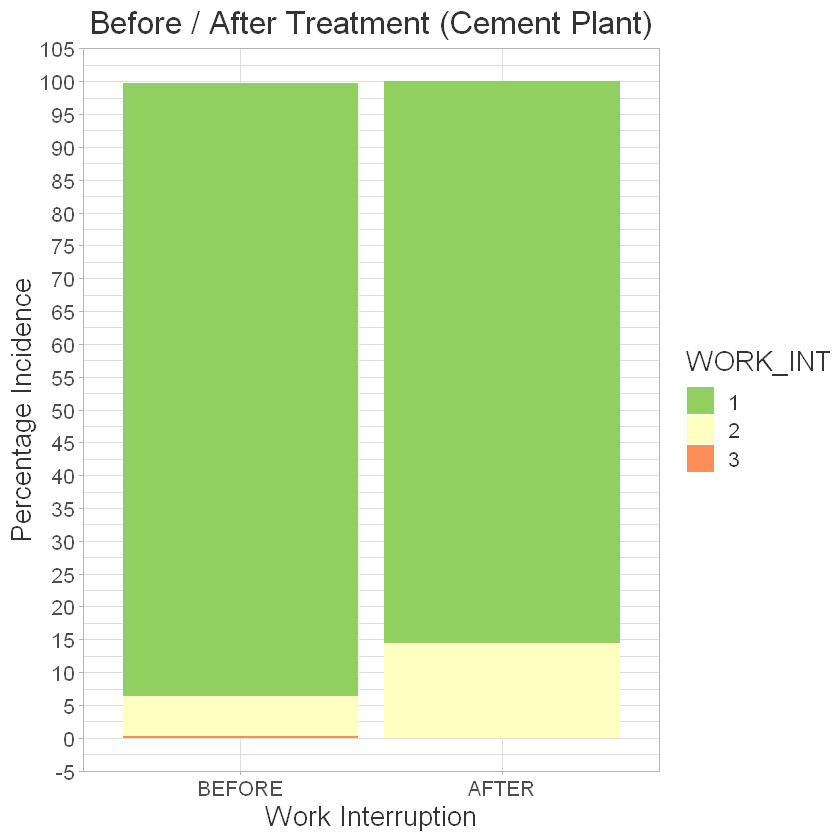

In [17]:
g7a <- ggplot(data = count7, mapping = aes(x = TREAT, y = n, fill=WORK_INT)) +
  theme_light() + 
#   theme(text=element_text(family = "Segoe UI", color="grey20", size=24),
#         plot.title = element_text(hjust = 0.5), 
#         plot.subtitle = element_text(hjust = 0.5)) +
  theme(text=element_text(color="grey20", size=16),
        plot.title = element_text(hjust = 0.5), 
        plot.subtitle = element_text(hjust = 0.5)) +
  labs(title = "Before / After Treatment (Cement Plant)", x = "Work Interruption", y = "Percentage Incidence") +
  geom_col() +
  scale_fill_brewer(palette="RdYlGn", direction = -1) +
  scale_y_continuous(breaks = scales::breaks_extended(n=20)) # + 
#   geom_text(aes(label = as.character(count7a$n), position = position_stack(vjust=0.5)))

g7a
# png(filename = "Before-After Work Int.png", width=1920/2, height=1080, pointsize = 18, type = "windows")
# plot(g7a)
# dev.off()